In [1]:
%matplotlib inline

In [2]:
import os,sys
import requests
from matplotlib import pyplot as plt
import numpy as np
sys.path.insert(0, os.path.abspath('../src'))
from interface import Detector, Run

# Some useful experiment information
## General experiment setup:

In [3]:
expt='cxic0415'

In [4]:
geom_file = f'/cds/data/psdm/cxi/{expt}/calib/CsPad::CalibV1/CxiDs1.0:Cspad.0/geometry/0-end.data'

In [5]:
det = Detector(geom_file)

## some run specifics

In [6]:
run_idx=36

In [7]:
run = Run(expt, run_idx, det=det, image_type=np.int16)

9158 images of shape 1738x1747 and type int16
Estimated size: 55.61 GB


# PCA of a small batch

In [8]:
images = run._retrieve_image_batch()

In [31]:
def show_image(image, title=None):
    vmin = np.mean(image)-3*np.std(image)
    vmax = np.mean(image)+3*np.std(image)
    fig, ax = plt.subplots(1,1,figsize=(3,3),dpi=180)
    if title is not None:
        ax.set_title(title)
    im = ax.imshow(image, vmin=vmin, vmax=vmax)
    fig.colorbar(im, orientation='vertical')
    plt.show()

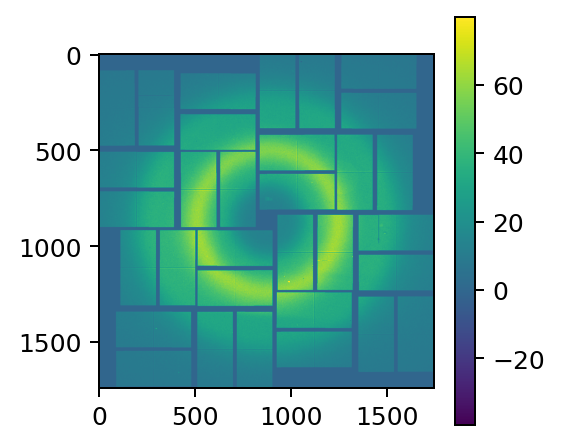

In [32]:
show_image(np.mean(images,axis=0))

In [16]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA()
pca.fit(images.reshape(images.shape[0], images.shape[1]*images.shape[2]))

PCA()

In [20]:
comps = pca.transform(images.reshape(images.shape[0], images.shape[1]*images.shape[2]))

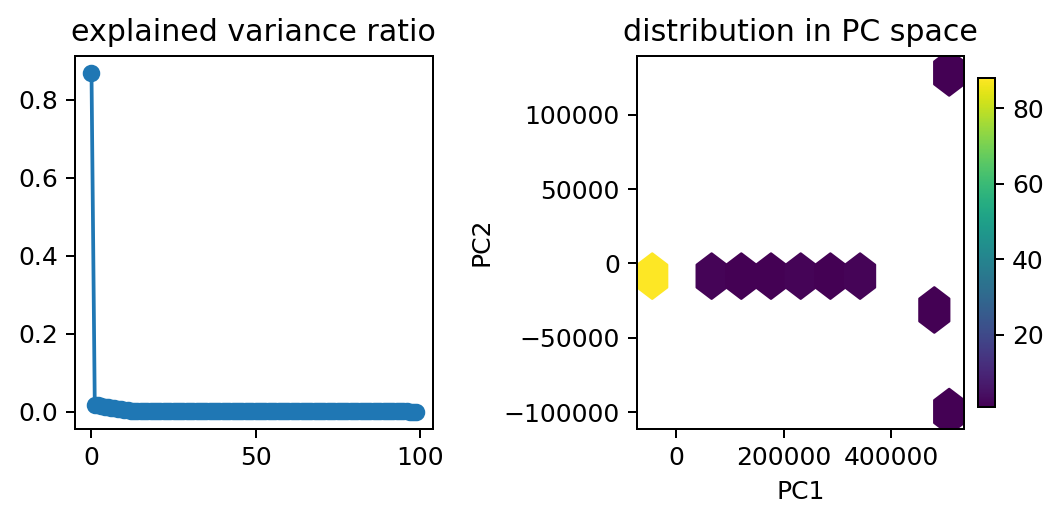

In [27]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,3),dpi=180)
ax1.set_title('explained variance ratio')
ax1.plot(pca.explained_variance_ratio_, 'o-')
ax2.set_title('distribution in PC space')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
im2 = ax2.hexbin(comps[:,0], comps[:,1], mincnt=1,gridsize=10)
cbar = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [29]:
eigen_images = np.dot(comps.T,images.reshape(images.shape[0], images.shape[1]*images.shape[2])).reshape(images.shape[0], images.shape[1], images.shape[2])

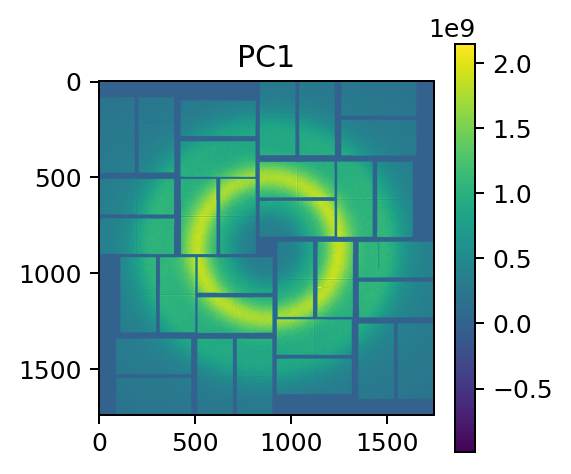

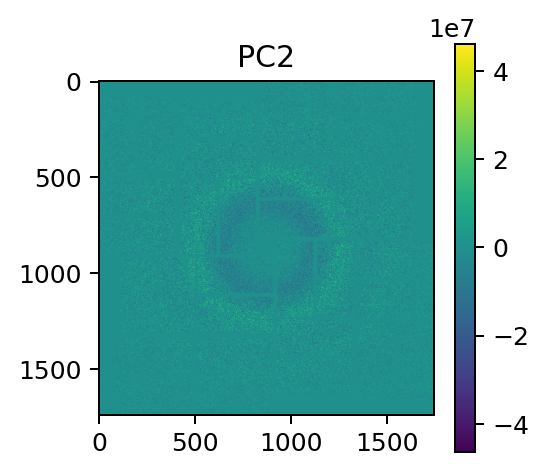

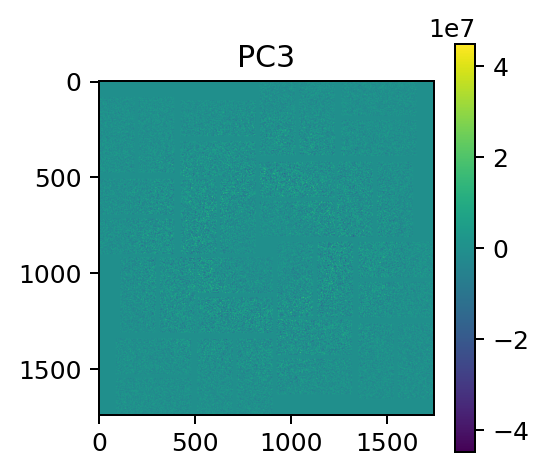

In [33]:
for i in np.arange(3):
    show_image(eigen_images[i], title=f'PC{i+1}')

## some low level clustering

In [34]:
bulk_indices     = np.where(comps[:,0]<0)[0]
outliers_indices = np.where(comps[:,0]>0)[0]
print(bulk_indices.shape, outliers_indices.shape)

bulk_images     = np.copy(images[bulk_indices,...])
outliers_images = np.copy(images[outliers_indices,...])

bulk_mean     = np.mean(bulk_images,axis=0) 
outliers_mean = np.mean(outliers_images,axis=0) 
bulk_std     = np.std(bulk_images,axis=0) 
outliers_std = np.std(outliers_images,axis=0) 

(88,) (12,)


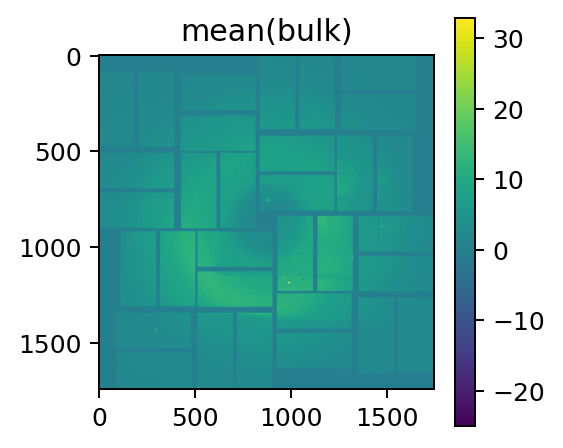

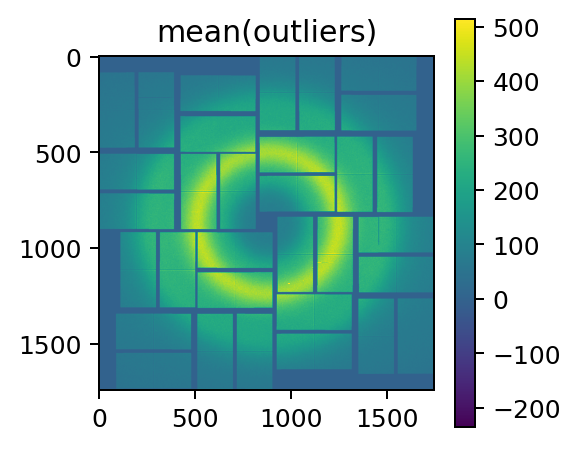

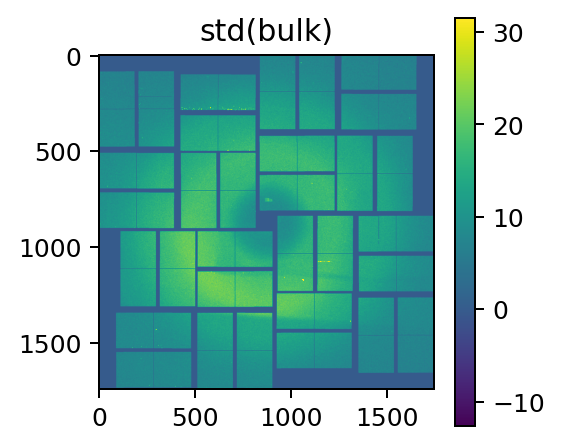

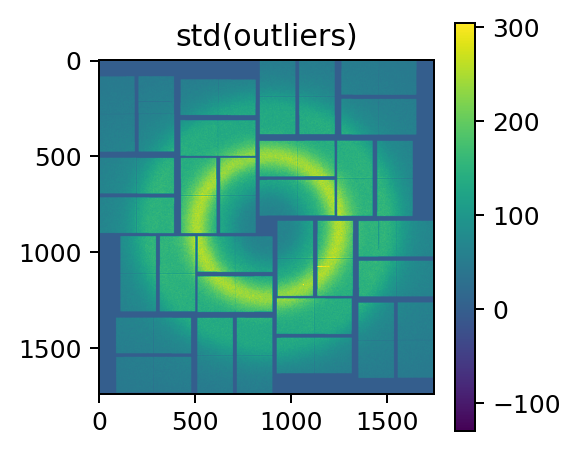

In [41]:
for image, title in zip((bulk_mean, outliers_mean, bulk_std, outliers_std),('mean(bulk)','mean(outliers)','std(bulk)','std(outliers)')):
    show_image(image, title=title)

# PCA of the whole run